# SN Local and Global
This notebook contains:
* First analysis of SN on the local and global level.
* Contains the metrics plots.

# Preamble

In [1]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from enum import Enum
from dask.diagnostics import ProgressBar


# Custom xarray classes that addes different method.
import xarray_class_accessors as xca

# Custom plots for signal to noise functions.
import sn_plotting as sn_plot

In [13]:
# The directory where all of the longrun mip data used in this notebook is stored.
ROOT_DIR = '/g/data/w40/ab2313/longrunmip'

In [14]:
# It takes a while to run the loess filter for each grid cell. So this has been pre-generated and saved.
LOESS_ROOT = os.path.join(ROOT_DIR, 'loess')
LOESS_ROOT

'/g/data/w40/ab2313/longrunmip/loess'

In [15]:
# All the files that have been loess filtered. 
# TODO: Consistent naming format. Some files have _loess at the end, whilst others do not.
os.listdir(LOESS_ROOT)

['tas_mon_CCSM3_control_1530_loess.nc', 'tas_mon_CCSM3_abrupt4x_2120.nc']

In [16]:
IMG_DIR = '../../images/PhD/init'

In [17]:
model = 'CCSM3'

In [18]:
os.listdir(IMG_DIR)

['4xCO2_1%_ECH_SN.png',
 '4xCO2_1%_ECH_SN_60window.png',
 '4xCO2_1%_ECH_SN_60Ywindow.png',
 'CCSM3_upper_lower_control_bounds.png',
 'CCSM3_stable_metrics.png',
 'CCSM3_1000_sn.png',
 'CCSM3_10_sn.png',
 'CCSM3_global_sn_temp_anomaly.png',
 'CCSM3_Epacific_sn_temp_anomaly.png',
 'CCSM3_Natlantic_sn_temp_anomaly.png',
 'CCSM3_Echina_sea_sn_temp_anomaly.png',
 'CCSM3_Melbourne_sn_temp_anomaly.png',
 'CCSM3_London_sn_temp_anomaly.png',
 'CCSM3_Ny_sn_temp_anomaly.png',
 'CCSM3_Beijing_sn_temp_anomaly.png',
 'CCSM3_Buenos_aires_sn_temp_anomaly.png',
 'CCSM3_Kinshasa_sn_temp_anomaly.png',
 'CCSM3_Artic_sn_temp_anomaly.png']

In [19]:
class Locations(Enum):
    EPACIFIC = (2.7 ,-85)
    NATLANTIC = (2.2, -8)
    ECHINA_SEA = (26, 128)
    MELBOURNE = (-38, 145)
    LONDON = (51, 0.12)
    NY = (40, 74)
    BEIJING = (40, 116) 
    BUENOS_AIRES = (35, 58)
    KINSHASA = (4.4, 15.2)
    ARTIC = (76, 100)

# Control
THe SN for the piControl is get the stable/unstable bounds for each gridcell. This is to work out what can be considered natural variabilbity of the system.

In [20]:
control = xr.open_dataset(os.path.join(ROOT_DIR,'tas_mon_CCSM3_control_1530.nc' )).tas

# Applying corrections.
control = control.correct_data.apply_corrections()

# Only want the yearly average. This needs to be done after corrections. 
control = control.resample(time='Y').mean()
control 

Testing months in each year...
Inital time length: 18360
- First year removed: 11 month(s) in year 1
- Last year removed:  1 month(s) in year 1531

Data Correction complete - all years now have 12 months
Final time length: 18348


<xarray.DataArray 'tas' (time: 1529, lat: 48, lon: 96)>
array([[[235.86493, 235.50179, 235.13353, ..., 236.84892, 236.5406 ,
         236.21118],
        [238.37079, 237.22215, 236.04646, ..., 241.35016, 240.44713,
         239.43877],
        [239.8416 , 237.90228, 235.96063, ..., 245.24316, 243.58911,
         241.77766],
        ...,
        [263.8774 , 265.18118, 265.90146, ..., 260.20456, 261.0649 ,
         262.254  ],
        [259.6686 , 260.0328 , 260.38202, ..., 258.26068, 258.76355,
         259.19073],
        [257.916  , 258.03632, 258.14853, ..., 257.6398 , 257.74213,
         257.83652]],

       [[235.3564 , 235.00415, 234.61969, ..., 236.33803, 236.03725,
         235.70268],
        [238.57758, 237.47261, 236.32445, ..., 241.50392, 240.60963,
         239.63506],
        [240.41597, 238.6551 , 236.8991 , ..., 245.48674, 243.87451,
         242.17317],
...
        [261.66296, 262.09494, 261.9867 , ..., 257.4562 , 258.64508,
         260.29572],
        [255.53589, 255.74329, 255.88863, ..., 254.16583, 254.63136,
         255.0341 ],
        [254.41034, 254.4991 , 254.58026, ..., 254.20654, 254.28532,
         254.35356]],

       [[233.48418, 233.03755, 232.58012, ..., 234.77235, 234.35268,
         233.93048],
        [235.1908 , 233.85356, 232.4763 , ..., 238.80861, 237.67389,
         236.47026],
        [237.7293 , 235.61786, 233.48466, ..., 243.38203, 241.64429,
         239.75859],
        ...,
        [259.55725, 259.8377 , 259.89133, ..., 257.08185, 258.07437,
         258.9237 ],
        [254.2987 , 254.48146, 254.70123, ..., 253.26869, 253.6573 ,
         253.95363],
        [253.09596, 253.20906, 253.30907, ..., 252.81451, 252.92323,
         253.01819]]], dtype=float32)
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [21]:
# Opening the loess filtered data for the control.
loess_control = xr.open_dataset(os.path.join(LOESS_ROOT,'tas_mon_CCSM3_control_1530_loess.nc' )).tas
loess_control

<xarray.DataArray 'tas' (time: 1529, lat: 48, lon: 96)>
[7045632 values with dtype=float64]
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    history:  Modified by Alex Borowiak on 2021/08/03
    stats:    loess detrended data

In [22]:
control_anom = control.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])
control_anom

<xarray.DataArray 'tas' (time: 1529, lat: 48, lon: 96)>
dask.array<xarray-<this-array>, shape=(1529, 48, 96), dtype=float32, chunksize=(8, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [23]:
control_signal = control_anom.sn.signal_grad() # Anomalies not used origonally
control_signal

<xarray.DataArray 'signal' (time: 1469, lat: 48, lon: 96)>
dask.array<getitem, shape=(1469, 48, 96), dtype=float64, chunksize=(64, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1470-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [24]:
# The noise is calculated using the loess filtered data.
control_noise = loess_control.sn.noise_grad()
control_noise

<xarray.DataArray 'noise' (time: 1469, lat: 48, lon: 96)>
array([[[0.86847721, 0.86849208, 0.87006587, ..., 0.87007624,
         0.86906773, 0.86801151],
        [0.8275722 , 0.83115343, 0.83598663, ..., 0.83428795,
         0.83017444, 0.8263911 ],
        [0.7700978 , 0.79245702, 0.81640932, ..., 0.77480151,
         0.7641177 , 0.7613571 ],
        ...,
        [2.69462179, 2.85728432, 2.85037657, ..., 1.7593971 ,
         2.04084032, 2.36896872],
        [1.71333056, 1.7658477 , 1.80543817, ..., 1.49310018,
         1.55931951, 1.6342738 ],
        [1.2775504 , 1.29001909, 1.29973754, ..., 1.25708015,
         1.26532433, 1.272511  ]],

       [[0.84751029, 0.84725144, 0.84858345, ..., 0.85048798,
         0.84894365, 0.847466  ],
        [0.80684402, 0.81101147, 0.81682899, ..., 0.81696226,
         0.81094416, 0.80626162],
        [0.7628262 , 0.78613847, 0.8116232 , ..., 0.76942914,
         0.75661141, 0.75293084],
...
        [2.13671329, 2.07959397, 1.95886949, ..., 1.54465329,
         1.82476617, 2.03676605],
        [1.34640931, 1.35466807, 1.34705033, ..., 1.23821112,
         1.28222162, 1.31942033],
        [0.90208576, 0.91358878, 0.92036057, ..., 0.86602214,
         0.88129955, 0.89282285]],

       [[0.77346012, 0.78021515, 0.78484943, ..., 0.75939703,
         0.76354075, 0.76835296],
        [0.73495057, 0.74057637, 0.75088508, ..., 0.72299905,
         0.72288379, 0.72637233],
        [0.72605968, 0.73847878, 0.75310968, ..., 0.72832523,
         0.71998789, 0.71906382],
        ...,
        [2.13953246, 2.08480941, 1.96426588, ..., 1.55136543,
         1.8273113 , 2.03817346],
        [1.38698566, 1.39528181, 1.38590479, ..., 1.27348586,
         1.32060784, 1.35967856],
        [0.94657369, 0.95785295, 0.96416241, ..., 0.91008165,
         0.92556611, 0.93730274]]])
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1470-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    history:  Modified by Alex Borowiak on 2021/08/03
    stats:    loess detrended data

In [25]:
# Signal to noise ratio.
control_sn = control_signal/control_noise
control_sn

<xarray.DataArray (time: 1469, lat: 48, lon: 96)>
dask.array<truediv, shape=(1469, 48, 96), dtype=float64, chunksize=(64, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1470-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [26]:
# The bounds of what can be considered an increasing (90th percentile)
# and a decreasing trend (10th percentile).
control_sn_ubound = control_sn.reduce(xca.dask_percentile,dim='time', q=90)
control_sn_lbound = control_sn.reduce(xca.dask_percentile,dim='time', q=10)

In [27]:
# Finally, something that is fast with the processes scheduler.
with ProgressBar():
    control_sn_ubound = control_sn_ubound.compute(scheduler='processes')

[########################################] | 100% Completed |  3min 42.6s


In [28]:
with ProgressBar():
    control_sn_lbound = control_sn_lbound.compute(scheduler='processes')

[########################################] | 100% Completed |  5min 19.2s


In [29]:
control_sn_lbound 

<xarray.DataArray (lat: 48, lon: 96)>
array([[-0.63860061, -0.64192723, -0.6519387 , ..., -0.63623021,
        -0.63218869, -0.63665812],
       [-0.57150161, -0.5685807 , -0.568236  , ..., -0.59577129,
        -0.59286632, -0.57428151],
       [-0.56594439, -0.56670682, -0.57044981, ..., -0.63188865,
        -0.59936874, -0.57691282],
       ...,
       [-0.98834573, -1.00733223, -1.0160258 , ..., -1.00725885,
        -0.96378252, -0.96520708],
       [-0.85352192, -0.85650472, -0.84976277, ..., -0.87082663,
        -0.86379789, -0.8521074 ],
       [-0.79102848, -0.79018725, -0.7850564 , ..., -0.81411079,
        -0.80378555, -0.79737694]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [30]:
control_sn_ubound.max().values

array(1.53245017)

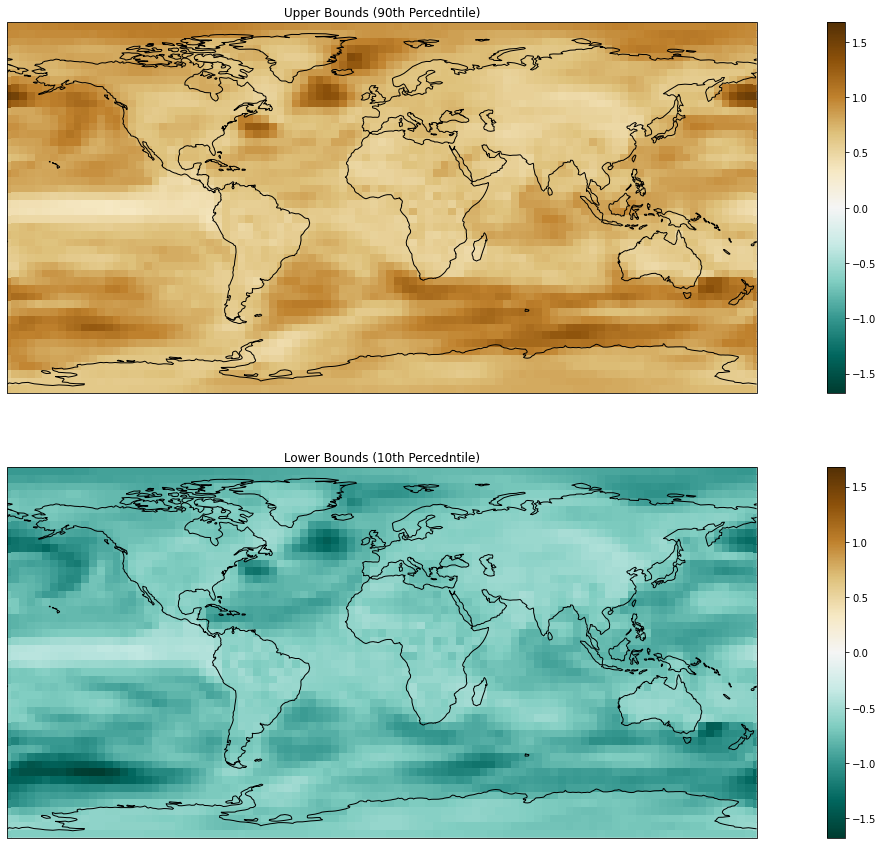

In [31]:
fig = plt.figure(figsize = (25,15))

vmax = control_sn_ubound.max().values
vmin = control_sn_lbound.min().values

vmax = np.max([vmin, np.abs(vmin)])
vmin = -vmax

ax = fig.add_subplot(211, projection=ccrs.PlateCarree())
control_sn_ubound.plot(ax=ax, cmap='BrBG_r', vmin = vmin, vmax = vmax)
ax.coastlines()
ax.set_title('Upper Bounds (90th Percedntile)')


ax = fig.add_subplot(212, projection=ccrs.PlateCarree())
control_sn_lbound.plot(ax=ax, cmap='BrBG_r', vmin = vmin, vmax = vmax)
ax.coastlines()
ax.set_title('Lower Bounds (10th Percedntile)')

fig.savefig(f'{IMG_DIR}/{model}_upper_lower_control_bounds.png', bbox_inches='tight', dpi=500)

# QuadCO2
Running the same codes as above, but for a run where the CO2 has been quadrupled. 

In [32]:
abrupt = xr.open_dataset(os.path.join(ROOT_DIR,'tas_mon_CCSM3_abrupt4x_2120.nc' )).tas

abrupt = abrupt.correct_data.apply_corrections()

abrupt = abrupt.resample(time='Y').mean()
abrupt 

Testing months in each year...
Inital time length: 25440
- First year removed: 11 month(s) in year 1
- Last year removed:  1 month(s) in year 2121
- Incorrect year detected and time overridden

Data Correction complete - all years now have 12 months
Final time length: 25428


<xarray.DataArray 'tas' (time: 2119, lat: 48, lon: 96)>
array([[[238.17262, 237.81415, 237.4554 , ..., 239.1385 , 238.8279 ,
         238.50989],
        [240.75873, 239.70117, 238.63087, ..., 243.5872 , 242.70825,
         241.76225],
        [242.45258, 240.6974 , 238.99084, ..., 247.44733, 245.88509,
         244.20746],
        ...,
        [262.82187, 264.01248, 264.89276, ..., 261.59412, 261.6085 ,
         262.00278],
        [260.01486, 260.19543, 260.38647, ..., 259.27866, 259.56528,
         259.77042],
        [259.1821 , 259.24893, 259.3114 , ..., 259.05426, 259.10065,
         259.13828]],

       [[236.11565, 235.787  , 235.43633, ..., 237.04193, 236.75072,
         236.44154],
        [238.8268 , 237.8432 , 236.84479, ..., 241.58934, 240.73964,
         239.8091 ],
        [240.69069, 239.06734, 237.50099, ..., 245.6093 , 244.02362,
         242.36903],
...
        [271.12576, 271.3906 , 271.444  , ..., 268.50244, 269.7305 ,
         270.5875 ],
        [267.8196 , 267.98868, 268.12393, ..., 266.86157, 267.26968,
         267.56277],
        [266.82373, 266.8773 , 266.92075, ..., 266.59106, 266.68405,
         266.76785]],

       [[241.1106 , 240.7738 , 240.43372, ..., 242.04884, 241.74658,
         241.43355],
        [244.29964, 243.29948, 242.2906 , ..., 247.20032, 246.26624,
         245.28731],
        [246.07825, 244.34969, 242.72267, ..., 251.67986, 249.80945,
         247.9226 ],
        ...,
        [271.35434, 271.63284, 271.68005, ..., 269.0222 , 269.98453,
         270.77737],
        [267.91116, 268.19626, 268.4202 , ..., 266.73145, 267.15375,
         267.52435],
        [267.3329 , 267.40015, 267.4672 , ..., 267.05527, 267.15005,
         267.25082]]], dtype=float32)
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2120-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [33]:
abrupt.time.values[0]

cftime.DatetimeNoLeap(2, 12, 31, 0, 0, 0, 0, has_year_zero=True)

In [34]:
# Getting the temperature anomalies.
abrupt_anom = abrupt.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1],
                            historical = control)

Using historical dataset


In [35]:
abrupt_anom 

<xarray.DataArray 'tas' (time: 2119, lat: 48, lon: 96)>
dask.array<xarray-<this-array>, shape=(2119, 48, 96), dtype=float32, chunksize=(8, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2120-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [36]:
# The pre-filtere loess data.
loess_abrupt = xr.open_dataset(os.path.join(LOESS_ROOT,'tas_mon_CCSM3_abrupt4x_2120.nc' )).tas
loess_abrupt

<xarray.DataArray 'tas' (time: 2119, lat: 48, lon: 96)>
[9764352 values with dtype=float64]
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2120-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    history:  Modified by Alex Borowiak on 2021/08/03
    stats:    loess detrended data

In [37]:
%%time
# Calculating the singal to noise.

# Signal
abrupt_signal = abrupt_anom.sn.signal_grad()

# Noise
abrupt_noise = loess_abrupt.sn.noise_grad()

# S/N
abrupt_sn = abrupt_signal/abrupt_noise
abrupt_sn

CPU times: user 592 ms, sys: 107 ms, total: 699 ms
Wall time: 1.3 s


<xarray.DataArray (time: 2059, lat: 48, lon: 96)>
dask.array<truediv, shape=(2059, 48, 96), dtype=float64, chunksize=(64, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2060-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [38]:
with ProgressBar():
    abrupt_sn = abrupt_sn.compute()

[########################################] | 100% Completed |  1hr  7min  7.8s


In [39]:
# Finding where the singal to noise is increasing unstable and decreasing 
# unstable using the bounds defined by the percentiles of the contorl run.
abrupt_sn_increasing_unstable = abrupt_sn.where(abrupt_sn > control_sn_ubound)
abrupt_sn_decreasing_unstable = abrupt_sn.where(abrupt_sn < control_sn_lbound)

In [40]:
# SN
# The stable signal-to-noise points
abrupt_sn_stable = abrupt_sn.where(
    np.logical_and(
                        abrupt_sn <= control_sn_ubound,
                        abrupt_sn >= control_sn_lbound
                            )
                                  )
abrupt_sn_stable.name = 'sn'

# TEMP
# The stalbe temperature points.
abrupt_anom_stable = abrupt_anom.where(
    np.logical_and(
                        abrupt_sn <= control_sn_ubound,
                        abrupt_sn >= control_sn_lbound
                            )
                                  )


In [41]:
abrupt_anom_stable

<xarray.DataArray 'tas' (time: 2059, lat: 48, lon: 96)>
dask.array<where, shape=(2059, 48, 96), dtype=float32, chunksize=(8, 48, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2060-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [42]:
abrupt_sn_stable

<xarray.DataArray 'sn' (time: 2059, lat: 48, lon: 96)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.57030468,         nan,         nan, ...,  0.39578345,
          0.46534725,  0.16727193],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.43539646, -0.42782285, -0.43163095, ..., -0.47996015,
         -0.46007773, -0.45013705],
        [ 0.02681494,  0.05138612,  0.07104169, ..., -0.09910665,
         -0.05017674, -0.00868887],
        [ 0.38809429,  0.38442838,  0.35965803, ...,  0.21688251,
          0.28964144,  0.35649648],
        ...,
        [-0.63628279,         nan,         nan, ...,  0.3540895 ,
          0.41470257,  0.09991861],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 2060-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

## Plots Samples

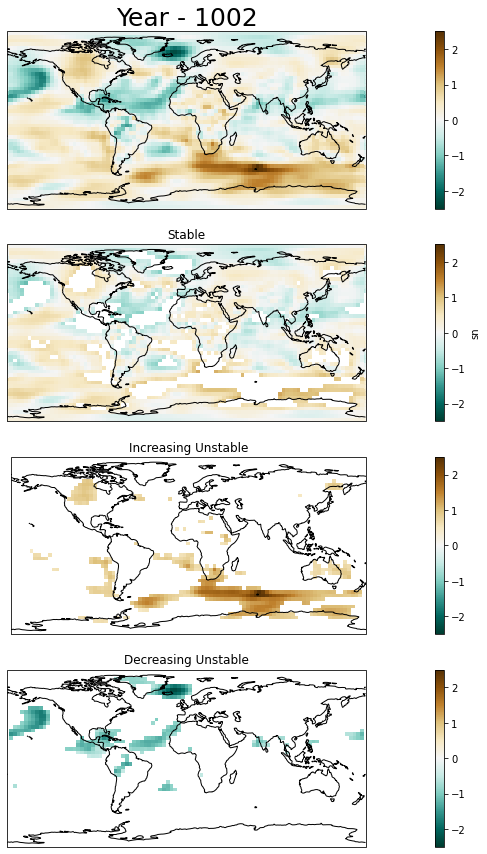

In [43]:
fig = plt.figure(figsize = (25,15))
time_index = 1000


ax = fig.add_subplot(411, projection=ccrs.PlateCarree())
plot1 = abrupt_sn.isel(time = time_index).plot(ax=ax, cmap='BrBG_r')
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title(f'Year - {time_val.year}', fontsize = 25)


ax = fig.add_subplot(412, projection=ccrs.PlateCarree())
abrupt_sn_stable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Stable')


ax = fig.add_subplot(413, projection=ccrs.PlateCarree())
abrupt_sn_increasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Increasing Unstable');



ax = fig.add_subplot(414, projection=ccrs.PlateCarree())
abrupt_sn_decreasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Decreasing Unstable');

fig.savefig(f'{IMG_DIR}/{model}_{time_index}_sn.png', bbox_inches='tight', dpi=500)

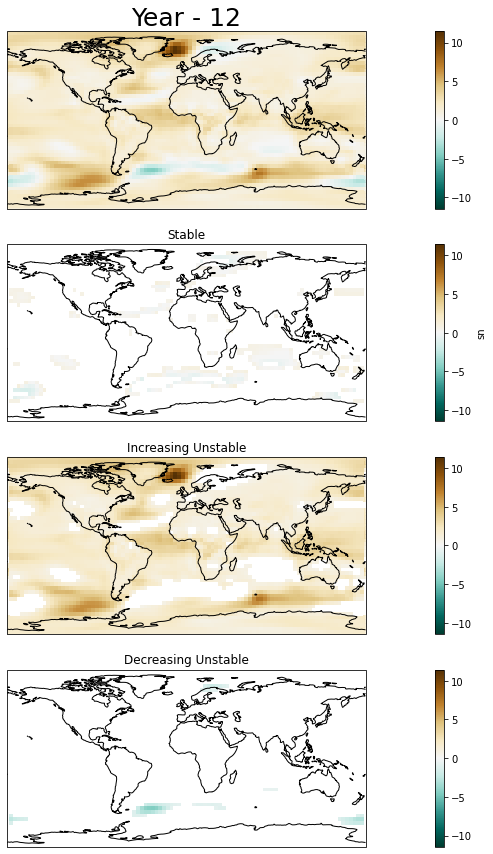

In [44]:
fig = plt.figure(figsize = (25,15))
time_index = 10


ax = fig.add_subplot(411, projection=ccrs.PlateCarree())
plot1 = abrupt_sn.isel(time = time_index).plot(ax=ax, cmap='BrBG_r')
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title(f'Year - {time_val.year}', fontsize = 25)


ax = fig.add_subplot(412, projection=ccrs.PlateCarree())
abrupt_sn_stable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Stable')


ax = fig.add_subplot(413, projection=ccrs.PlateCarree())
abrupt_sn_increasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Increasing Unstable');



ax = fig.add_subplot(414, projection=ccrs.PlateCarree())
abrupt_sn_decreasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = abrupt_sn.time.values[time_index]
ax.set_title('Decreasing Unstable');

fig.savefig(f'{IMG_DIR}/{model}_{time_index}_sn.png', bbox_inches='tight', dpi=500)

# Consect and First Instance

In [43]:
# Consectuvie metrics are a bunch of values to unpack what is happening with all the stable points.
# This includes how long till the trend first stabalises, the total number of times the trend stabalises ect.
with ProgressBar():
#     abrupt_sn_stable.sn.calculate_consecutive_metrics()
    stable_ds = abrupt_sn_stable.sn.calculate_consecutive_metrics()

In [47]:
stable_ds = stable_ds.drop('total_time_stable')

In [48]:
stable_ds

<xarray.Dataset>
Dimensions:              (lat: 48, lon: 96)
Coordinates:
    time                 object 0002-12-31 00:00:00
  * lat                  (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                  (lon) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
Data variables:
    first_stable         (lat, lon) float64 18.0 18.0 18.0 ... 40.0 40.0 40.0
    average_length       (lat, lon) float64 17.1 16.33 17.0 ... 18.6 18.26 19.37
    number_periods       (lat, lon) float64 90.0 94.0 91.0 ... 68.0 69.0 65.0
    percent_time_stable  (lat, lon) float64 74.75 74.55 75.13 ... 61.19 61.15

In [49]:
stable_ds.first_stable.attrs = {"long_name": "** First Year Stable", 'units':'year'}
stable_ds.average_length.attrs = {"long_name": "** Average Length of Stable Periods", 'units':'year'}
stable_ds.number_periods.attrs = {"long_name": "** Number of Different Stable Periods", 'units':''}
stable_ds.percent_time_stable.attrs = {"long_name": "** Percent of Time Stable", 'units':'%'}

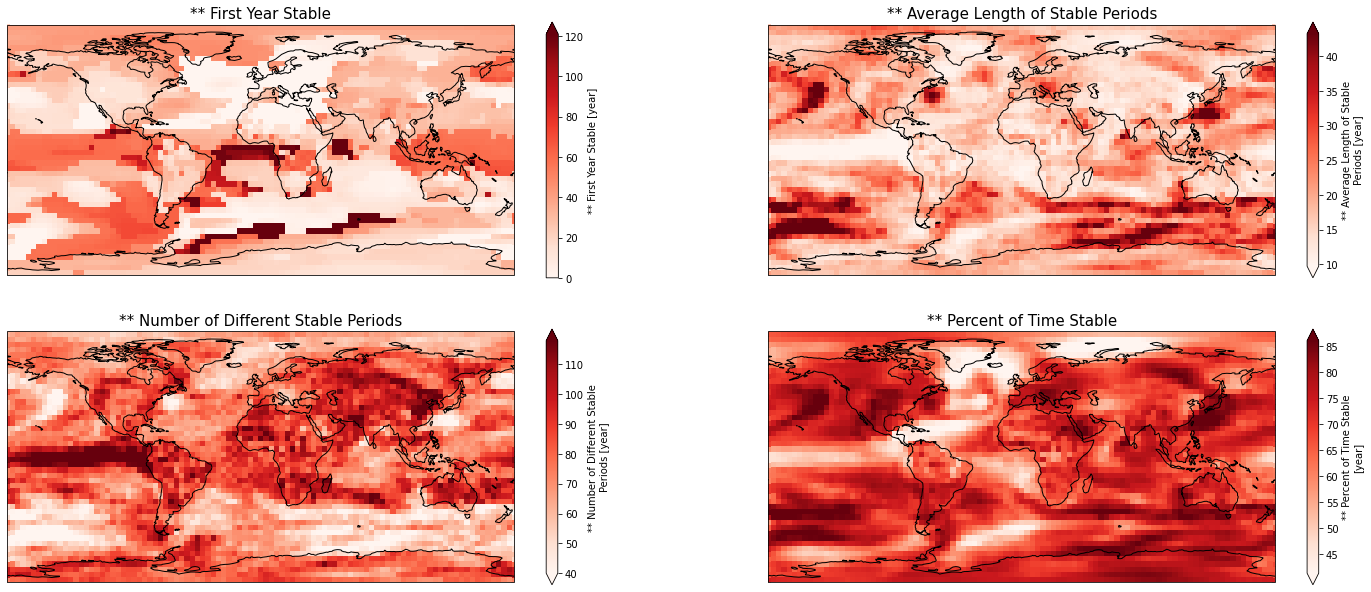

In [55]:
data_vars = list(stable_ds.data_vars)

figsize = (25, 4 * len(data_vars))
num_plots= len(data_vars)

fig = plt.figure(figsize=figsize)


for pnum, var in enumerate(data_vars):
    ax = fig.add_subplot(int(num_plots/2) + 1, 2, pnum + 1, projection=ccrs.PlateCarree())
    
    stable_ds[var].plot(ax=ax, cmap='Reds', robust=True)
    ax.coastlines()

    ax.set_title(stable_ds[var].long_name, size=15)
    
fig.savefig(f'{IMG_DIR}/{model}_stable_metrics.png', bbox_inches='tight', dpi=500)

#### Lat Lon Exploration

In [36]:
# Enum class defined above. This continas locations with a lat lon tuple

# Names
# loc_names = np.dstack(np.array([i.name for i in Locations]))

# # Lat and lon for each location
# locs = np.dstack(np.array([i.value for i in Locations]))
# lats, lons = locs[0][0], locs[0][1]

# with ProgressBar():
#     abrupt_sn_sub = abrupt_sn.sel(lat = lats, lon = lons, method='nearest').compute()#scheduler='processes')

In [37]:
loc = Locations.MELBOURNE

sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')

In [38]:
loc.name

'MELBOURNE'

In [39]:
reload(sn_plot)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/init/sn_plotting.py'>

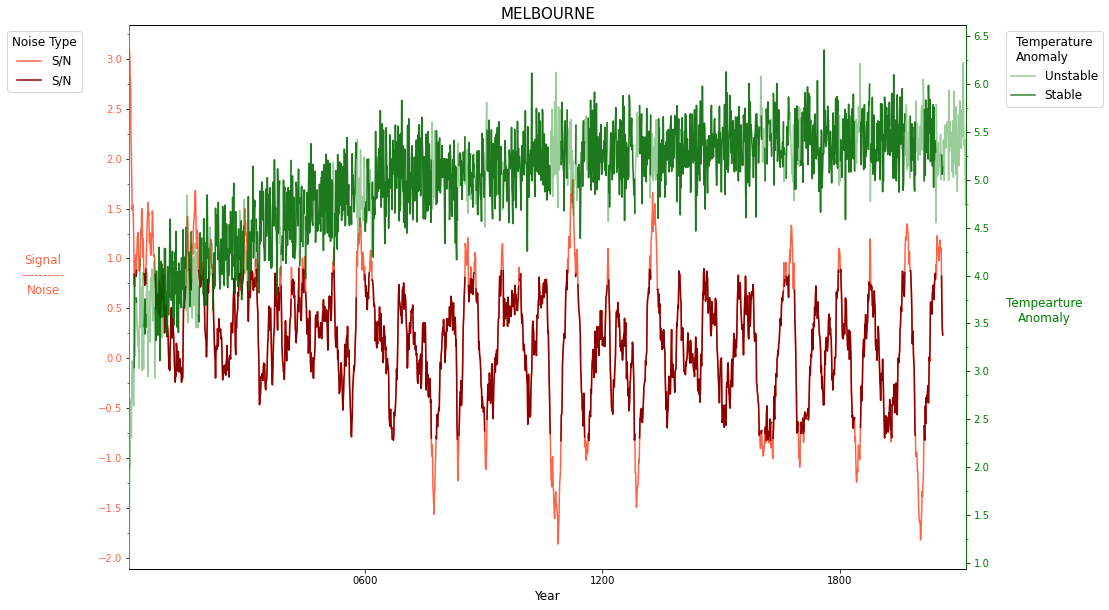

In [40]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                      temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                      sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

ax.set_title(loc.name, fontsize = 15);

In [41]:
loc.name.capitalize()

'Melbourne'

KeyboardInterrupt: 

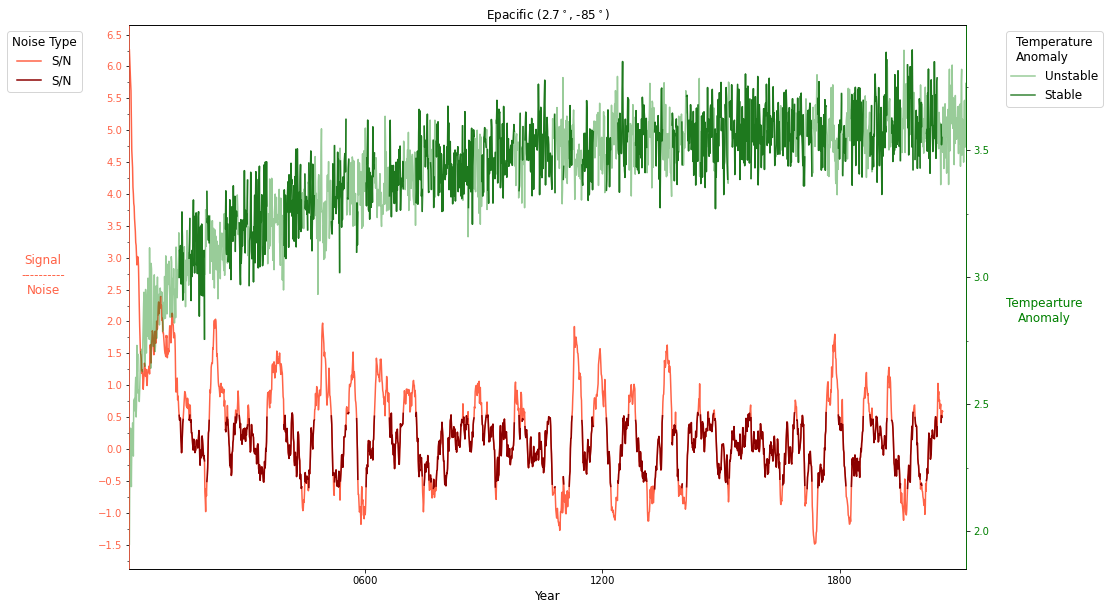

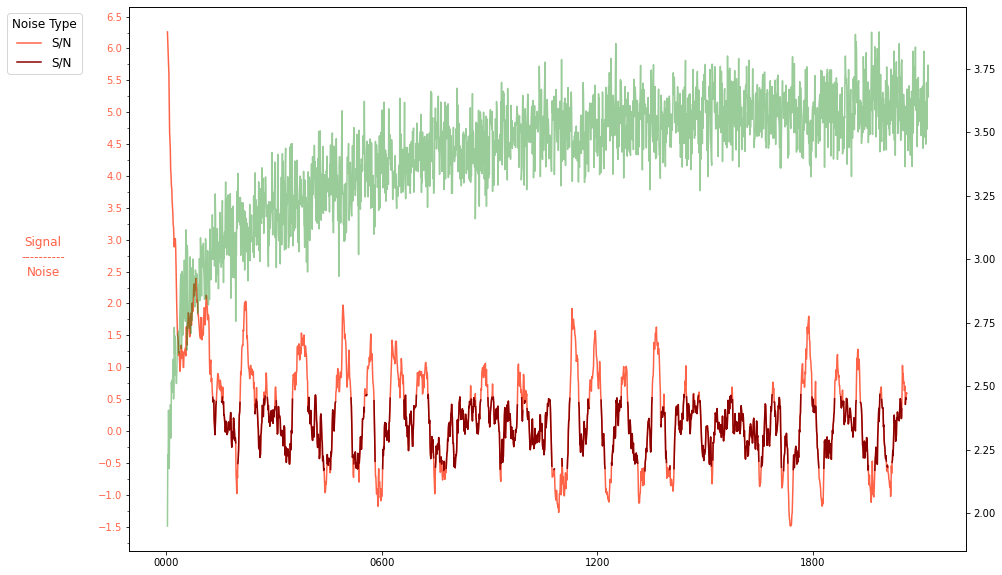

In [42]:
for loc in Locations:
    fig = plt.figure(figsize=  (15,10))
    ax = fig.add_subplot(111)


    sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')
    sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                          temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                          sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

    ax.set_title(f'{loc.name.capitalize()} ({loc.value[0]}$^\circ$, {loc.value[1]}$^\circ$)')
    
    fig.savefig(f'{IMG_DIR}/{model}_{loc.name.capitalize()}_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

# Global Mean

Calculating the s/n for the global mean. Each grid cell is then compared with the global mean.

## Control Bounds

In [ ]:
control_anom

In [ ]:
control_anom_smean = control_anom.clima.space_mean()

In [ ]:
control_anom_smean_signal = control_anom_smean.sn.signal_grad()

In [ ]:
control_anom_smean.sn.signal_grad()
control_anom_smean_loess = control_anom_smean.sn.loess_grid()
control_anom_smean_noise = control_anom_smean_loess.sn.noise_grad()

control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise

In [ ]:
control_anom_smean_sn

In [ ]:
control_anom_smean_sn.plot()

In [ ]:
control_smean_ubound = control_anom_smean_sn.reduce(np.nanpercentile, q=90, dim='time')
control_smean_lbound = control_anom_smean_sn.reduce(np.nanpercentile, q=10, dim='time')

In [ ]:
print(control_smean_lbound.values, control_smean_ubound.values)

## Abrupt Values

In [ ]:
abrupt_anom_smean = abrupt_anom.clima.space_mean()
abrupt_anom_smean

In [ ]:
abrupt_anom_smean_signal = abrupt_anom_smean.sn.signal_grad()
abrupt_anom_smean_signal

In [ ]:
abrupt_anom_smean_signal.plot()

plt.title('Signal - QUAD CO2')

In [ ]:
abrupt_anom_smean_loess = abrupt_anom_smean.sn.loess_grid()
abrupt_anom_smean_loess

In [ ]:
abrupt_anom_smean_loess.plot()

In [ ]:
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.noise_grad()
abrupt_anom_smean_noise

In [ ]:
abrupt_anom_smean_noise.plot()
plt.title('Noise - QUAD CO2')

In [ ]:
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise
abrupt_anom_smean_sn

In [ ]:
abrupt_anom_smean_sn.plot()
plt.title('S/N - QUAD CO2')

## Global Average Stable Bounds

In [ ]:
abrupt_anom_smean_sn

In [ ]:
# SN
# The global mean signal-to-noise points that are stable
abrupt_anom_smean_sn_stable = abrupt_anom_smean_sn.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

# TEMP
# The global mean temperature anomalies that are stable
abrupt_anom_smean_stable = abrupt_anom_smean.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

In [ ]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable)


fig.savefig(f'{IMG_DIR}/{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

In [ ]:
#The consecutive metrics
stable_smean_ds = abrupt_anom_smean_sn_stable.sn.calculate_consecutive_metrics().compute()

In [ ]:
stable_smean_ds.first_stable.values

In [ ]:
stable_smean_ds

# Grid Vs Global Space Mean

In [ ]:
stable_ds

In [ ]:
stable_ds['stable_year_anom_rel_global'] = stable_ds.first_stable - stable_smean_ds.first_stable.values

In [ ]:

figsize = (25, 8 )
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

stable_ds['stable_year_anom_rel_global'].plot(ax=ax, cmap='BrBG', robust=True, extend='both')
ax.coastlines()

ax.set_title('Stable Year Vs Global Stablisation')

# Animation Trials

In [ ]:
ANIMATION_DIR = '/g/data/w40/ab2313/animation'

In [ ]:
# os.mkdir(os.path.join(ANIMATION_DIR, 'animation'))

os.mkdir(os.path.join(ANIMATION_DIR,'raw_3'))

In [ ]:
RAW_DIR = os.path.join(ANIMATION_DIR,'raw_3')
RAW_DIR

In [ ]:
vmax = abrupt_sn_unstable.reduce(np.nanpercentile, q=99).values
vmin = abrupt_sn_unstable.reduce(np.nanpercentile, q=1).values
print(vmax, vmin)

In [ ]:
time = abrupt_sn.time.values

total = 0
for t in time[::10]:
    fig = plt.figure(figsize = (25,15))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    
    abrupt_sn_unstable.sel(time = t).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
    ax.coastlines()
    
    time_val = t.year
    
    ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
               bbox = {'facecolor':'white'});
    ax.set_title(f'')
    fig.savefig(os.path.join(RAW_DIR, f'{time_val}.png'))
    print(f'{time_val}, ', end='')
    plt.close()

In [ ]:
fig = plt.figure(figsize = (25,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

abrupt_sn_unstable.sel(time = t).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
ax.coastlines()

time_val = t.year

ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
           bbox = {'facecolor':'white'});
ax.set_title(f'')

In [ ]:
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import pyplot as plt, animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display


In [ ]:
fig = plt.figure(figsize = (25,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

cax = abrupt_sn_unstable.isel(time = 0).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
ax.coastlines()

time_val = t.year

ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
           bbox = {'facecolor':'white'});
ax.set_title(f'');


# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(abrupt_sn_unstable[frame,:,:].values.flatten())
#     ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-40, vmax=40,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
# RAW_DIR

# !convert /g/data/w40/ab2313/animation/raw_2/*png /g/data/w40/ab2313/animation/unstable_1.gif

# os.listdir(ANIMATION_DIR)

# !convert